# Predicting High Fire Areas in Montreal

## Summary:
**Dataset:** The dataset is a list of building fire incidents in the city of Montreal spanning from Jan 2015 to Sept 2022. Includes features relating to the incident and to the corresponding census tract area, collected from multiple sources.  
**Model:** Classifies the census tract areas (out of 540) which are expected to have a high number of fires per sq km in the following month. Random Forest and Logistic Regression model generated and compared. XGBoost added in appendix.  
**Particulars:** Feature engineering, feature selection, hyperparameter tuning, feature selection, imbalanced dataset, time lags, ROC curves

## Table of Contents:
* Section 0 - Customised Functions
* Section 1 - Data Preparation and Feature Engineering
* Section 2 - Exploratory Analaysis
* Section 3 - Data Preprocessing
* Section 4 - Feature Selection
* Section 5 - Hyperparamater Tuning
* Section 6 - Baseline Predictions
* Section 7 - Final Model Results
* Appendix - XGBoost

In [3]:
import math
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [4]:
print("Python version:", platform.python_version())

Python version: 3.7.12


In [5]:
pd.options.display.max_columns = None

# Section 0 - Customised Functions

List of functions created:
   * kfolds_func()
   * sampling_func()
   * data_clean_func()
   * fire_counts_func()
   * trig_transformation_func()

In [6]:
def kfolds_func(
    df_x, df_y, ovsamp_strat=0, unsamp_strat=0, n_splits=5, scale_values=False
):
    """
    Function generates k stratified training & test sets and applies over/under sampling to the training sets only.
    This enables cross validation without over/under sampling of the test sets.
    Option to scale values for parametric models.
    The first three items returned are passed into BayesSearchCV.
    """

    # Generating stratified k-fold indeces
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    skf_index = skf.split(df_x, df_y)

    df_train_x, df_train_y, df_test_x, df_test_y = dict(), dict(), dict(), dict()

    # Storing data sets in dictionaries, based on skf indeces, with dynamic key naming
    for i, (train_index, test_index) in enumerate(skf.split(df_x, df_y)):
        df_train_x[f"{i}"] = df_x.iloc[train_index]
        df_train_y[f"{i}"] = df_y.iloc[train_index]
        df_test_x[f"{i}"] = df_x.iloc[test_index]
        df_test_y[f"{i}"] = df_y.iloc[test_index]

    oversample = SMOTE(sampling_strategy=ovsamp_strat, random_state=1)
    undersample = RandomUnderSampler(sampling_strategy=unsamp_strat, random_state=1)
    df_x_final = pd.DataFrame()
    df_y_final = pd.DataFrame()
    index_tuples = list()
    floor = 0
    ceiling = 0

    for k in df_train_x.keys():
        # Applies scaling if option enabled
        if scale_values:
            scaler = MinMaxScaler()
            scaler.fit(df_train_x[k])
            df_train_x[k] = pd.DataFrame(
                scaler.transform(df_train_x[k]), columns=df_train_x[k].columns
            )
            df_test_x[k] = pd.DataFrame(
                scaler.transform(df_test_x[k]), columns=df_test_x[k].columns
            )

        # Applies over/under sampling to traning sets
        if ovsamp_strat != 0:
            df_train_x[k], df_train_y[k] = oversample.fit_resample(
                df_train_x[k], df_train_y[k]
            )
        if unsamp_strat != 0:
            df_train_x[k], df_train_y[k] = undersample.fit_resample(
                df_train_x[k], df_train_y[k]
            )

        # Tracks the indeces of training and test indeces for the final concatenated dataframe
        ceiling = floor + len(df_train_x[k])
        indeces_train = np.array(range(floor, ceiling))
        floor = ceiling
        ceiling = floor + len(df_test_x[k])
        indeces_test = np.array(range(floor, ceiling))
        floor = ceiling
        index_tuples.append((indeces_train, indeces_test))

        # Concatenates final training and test sets into a single dataframe
        df_x_final = pd.concat([df_x_final, df_train_x[k], df_test_x[k]], axis=0)
        df_y_final = pd.concat([df_y_final, df_train_y[k], df_test_y[k]], axis=0)

    # Resets index for the final concatenated dataset
    df_x_final = df_x_final.reset_index().drop(["index"], axis=1)
    df_y_final = df_y_final.reset_index().drop(["index"], axis=1)

    return (
        df_x_final,
        df_y_final,
        index_tuples,
        df_train_x,
        df_train_y,
        df_test_x,
        df_test_y,
    )

In [7]:
def sampling_func(df_x, df_y, ovsamp_strat, unsamp_strat):
    """
    Function applies over/under sampling on the entire dataset for final model training and predictions
    """
    oversample = SMOTE(sampling_strategy=ovsamp_strat, random_state=1)
    undersample = RandomUnderSampler(sampling_strategy=unsamp_strat, random_state=1)

    # Applies over/under sampling to traning sets
    if ovsamp_strat != 0:
        df_x, df_y = oversample.fit_resample(df_x, df_y)
    if unsamp_strat != 0:
        df_x, df_y = undersample.fit_resample(df_x, df_y)

    df_x_final = df_x.reset_index().drop(["index"], axis=1)
    df_y_final = df_y.reset_index().drop(["index"], axis=1)

    return df_x_final, df_y_final

In [8]:
def data_clean_func(df):
    """
    Data Preparation Function: Cleaning and scaling data
    """

    # Dropping non-predictive attribute columns
    df = df.drop(df.columns[[0, 2, 3, 4, 5, 6, 7]], axis=1)

    # Replacing null values with column averages
    null_attributes = ["A_AvgYear_Condo", "A_AvgYear_Regulier", "A_AvgYear_Other"]

    for attribute in null_attributes:
        df[attribute] = (
            df[attribute]
            .fillna(0)
            .replace(to_replace=0, value=df[df[attribute] != 0][attribute].mean())
        )

    # Scaling attributes by land area to compare census tract areas of different sizes
    scalable_attributes = [
        "A_Count_Coundo",
        "A_Count_Regulier",
        "A_Count_Other",
        "A_SumArea(sqm)_Condo",
        "A_SumArea(sqm)_Regulier",
        "A_SumArea(sqm)_Other",
    ]

    for attribute in scalable_attributes:
        df[attribute] = df[attribute] / df["CT_LandArea(sqkm)"]

    return df


def fire_counts_func(df):
    """
    Data Preparation Function: Aggregating fire count (densities) by census tract area and by month
    """

    global MIN_DATE
    global MAX_DATE
    global MAX_DATE_FULL
    global CT_DGUID_UNIQUE

    df_final = pd.DataFrame()

    # Converting incident timestamps to 'datetime' format and setting them as the index
    df["Fire_DateTime"] = pd.to_datetime(df["Fire_DateTime"])
    df = df.set_index("Fire_DateTime")

    # Finding the data ranges with complete months of data
    MIN_DATE = min(df.index).date()
    MAX_DATE = max(df.index).date()
    MAX_DATE_FULL = (MAX_DATE - pd.offsets.MonthEnd()).date()

    # Creating a date time index ranging the complete months of data
    monthly_index = pd.DatetimeIndex(
        pd.date_range(start=MIN_DATE, end=MAX_DATE_FULL, freq="M")
    )

    # Capturing the 540 unique census tract areas
    CT_DGUID_UNIQUE = sorted(df["CT_DGUID"].unique())

    for dguid in CT_DGUID_UNIQUE:
        # Filtering data by a specific census tract area (using DGUID identifier)
        df_dguid = df[df.loc[:, "CT_DGUID"] == dguid]

        # Generating dataframe with aggregated fire counts by month, falling within the monthly_index range
        df_counts = pd.DataFrame()
        df_counts["count"] = (
            df_dguid.resample("M").count().reindex(monthly_index).fillna(0)["CT_DGUID"]
        )
        # Scaling fire count by sqkm area (resulting in a fire count density)
        df_counts = df_counts / df_dguid["CT_LandArea(sqkm)"].iloc[0]

        # Generating matching dataframe with census tract area attributes
        dguid_attrs = pd.concat([df_dguid.iloc[[0]]] * df_counts.shape[0])
        dguid_attrs.index = df_counts.index

        # Combining counts with census tract area attributes
        df_counts = pd.concat([df_counts, dguid_attrs], axis=1)
        # Concatenating results into final dataframe which will reflect all census tract areas
        df_final = pd.concat([df_final, df_counts], axis=0)

        # Dropping land area column as it has been used to scale necessary values
        df_final = df_final.drop(["CT_LandArea(sqkm)"], axis=1)

    return df_final

In [9]:
def add_lag_features_func(df):
    """
    Feature Engineering Function: Generating the target column and 11 monthly lag features on the fire count (densities)
    """

    df_final = pd.DataFrame()

    for dguid in CT_DGUID_UNIQUE:
        # Filtering data by a specific census tract area (using DGUID identifier)
        df_dguid = df[df.loc[:, "CT_DGUID"] == dguid].copy()

        # Generating target column, reflecting the fire count (density) of the future month
        df_dguid["target"] = df_dguid["count"].shift(-1)

        # Generating 11 monthly lag features, reflecting fire count (densities) of previous months
        for lag in range(1, 12):
            df_dguid[f"lag_{lag}"] = df_dguid["count"].shift(lag)

        # Dropping rows capturing dates at the limit of the sliding window (11 months in back or 1 month in front)
        df_dguid = df_dguid.dropna()

        # Concatenating results into final dataframe which will reflect all census tract areas
        df_final = pd.concat([df_final, df_dguid], axis=0)

    # Aggregating and adding fire count densities over the past 3 month, 6 months, and 12 months
    lag_colums = [
        "count",
        "lag_1",
        "lag_2",
        "lag_3",
        "lag_4",
        "lag_5",
        "lag_6",
        "lag_7",
        "lag_8",
        "lag_9",
        "lag_10",
        "lag_11",
    ]

    df_final["last_3months"] = df_final[lag_colums[0:3]].sum(axis=1)
    df_final["last_6months"] = df_final[lag_colums[0:6]].sum(axis=1)
    df_final["last_12months"] = df_final[lag_colums[0:12]].sum(axis=1)

    return df_final


def trig_transformation_func(df):
    """
    Feature Engineering Function: Adding and encoding month and seasons columns as trigonometric coordinates
    """

    # Dictionary mapping 12 months to 4 seasons
    season_dict = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 3,
        9: 4,
        10: 4,
        11: 4,
        12: 1,
    }

    # Capturing months from datetime values
    df["month"] = df.index.month

    # Encoding month using trigonometic coordinates
    df["month_sin"] = df["month"].apply(lambda x: math.sin(2 * math.pi * x / 12))
    df["month_cos"] = df["month"].apply(lambda x: math.cos(2 * math.pi * x / 12))

    # Adding seasons and encoding using trigonometic coordinates
    df["season_sin"] = (
        df["month"]
        .apply(lambda x: season_dict[x])
        .apply(lambda x: math.sin(2 * math.pi * x / 4))
    )
    df["season_cos"] = (
        df["month"]
        .apply(lambda x: season_dict[x])
        .apply(lambda x: math.cos(2 * math.pi * x / 4))
    )

    df = df.drop(["month"], axis=1)

    return df

# Section 1 - Data Preparation and Feature Engineering

In [10]:
# Importing dataset: Fire incidents in Montreal (Jan 2015 to Sept 2022) with added attributes
df = pd.read_csv("fire_incidents_data.csv")
df.head(3)

,Fire_IncidentNo,Fire_DateTime,Fire_Type,Fire_Group,Fire_Ville,Fire_Arrond,Longitude,Latitude,CT_DGUID,CT_LandArea(sqkm),A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome
0,8328,2015-01-21 15:31:05,Feu / 4e Alerte,INCENDIE,Montréal,Côte-des-Neiges-Notre-Dame-de-Grâce,-73.627703,45.506320,2021S05074620123.00,0.4104,196,277,31,1957.734694,1948.700361,1961.615385,12538,195476,86068,15789.5,8.2,8.1,11.1,35.7,600000,29800
1,11888,2015-02-01 12:20:13,10-22 avec feu,INCENDIE,Montréal,Saint-Laurent,-73.727380,45.496187,2021S05074620415.09,9.8046,568,396,825,2003.896127,2000.398990,1986.680060,91317,156838,8357786,309.3,3.4,78.7,8.2,36.1,818000,53600
2,13353,2015-02-05 07:20:29,Feu / Agravation possible,INCENDIE,Montréal,Le Sud-Ouest,-73.599686,45.448475,2021S05074620090.00,0.4356,197,778,19,1986.850575,1951.252252,1950.375000,15638,239389,27059,10534.9,10.3,34.6,16.3,40.8,574000,33600


### Data preparation
><b>data_clean_func():</b> Cleaning and scaling data per sqkm

><b>def fire_counts_func():</b> Aggregating fire count (densities) by census tract area and by month
 
### Feature engineering
><b>add_lag_features_func():</b> Generating 11 monthly lag features on the fire count (densities). Generating aggregates of fire count densities over the past 3 month, 6 months, and 12 months. Also generating the target column, which is the fire count density value of the subsequent month.

><b>def trig_transformation_func(df):</b> Adding and encoding month and seasons columns as trigonometric coordinates

In [11]:
df_init = (
    df.pipe(data_clean_func)
    .pipe(fire_counts_func)
    .pipe(add_lag_features_func)
    .pipe(trig_transformation_func)
)
df_init.head(3)

,count,CT_DGUID,A_Count_Coundo,A_Count_Regulier,A_Count_Other,A_AvgYear_Condo,A_AvgYear_Regulier,A_AvgYear_Other,A_SumArea(sqm)_Condo,A_SumArea(sqm)_Regulier,A_SumArea(sqm)_Other,B_PopDensity(sqkm),C_%HousesNeedingMajorRepair,D_%Homeownership,E_%Population65+,F_AvgAge,G_AvgHomeValue,H_MedianIncome,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,last_3months,last_6months,last_12months,month_sin,month_cos,season_sin,season_cos
2015-12-31,0.00000,2021S05074620001.00,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.15378,0.00000,0.00000,2.15378,-2.449294e-16,1.000000,1.0,6.123234e-17
2016-01-31,0.00000,2021S05074620001.00,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,2.15378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,5.000000e-01,0.866025,1.0,6.123234e-17
2016-02-29,2.15378,2021S05074620001.00,626.749946,1025.199225,79.689856,2002.106529,1950.716102,1979.333333,48309.282791,268778.806806,134561.705794,5780.7,12.7,44.6,16.8,42.3,370000,40000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2.15378,2.15378,2.15378,8.660254e-01,0.500000,1.0,6.123234e-17


In [12]:
# Displaying dates range of fire incidents and of target values
print(
    f"""
Fire incidents: {MIN_DATE} to {MAX_DATE_FULL}
Target values:  {min(df_init.index).date().replace(day=1)} to {max(df_init.index).date()}
"""
)


Fire incidents: 2015-01-01 to 2022-08-31
Target values:  2015-12-01 to 2022-07-31



### Data preparation continued
>Converting the target variable (fire count density) into binary: high and low 

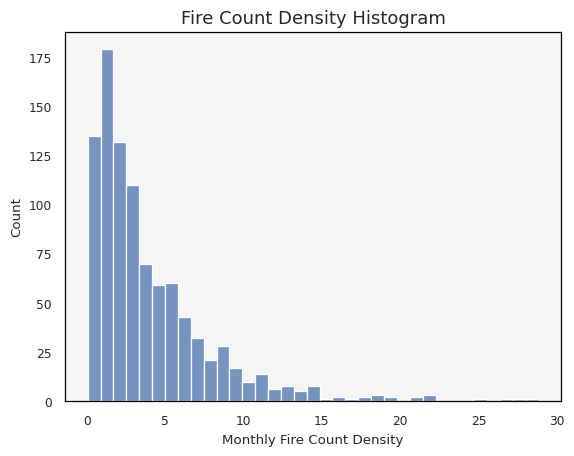

In [13]:
# Generating histogram of the target variable (fire count density)

target_counts = (
    df_init["target"]
    .value_counts()
    .to_frame()
    .reset_index()
    .set_axis(["target", "count"], axis="columns")
)

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.histplot(data=target_counts[1:], x="target")
plt.xlabel("Monthly Fire Count Density")
plt.title("Fire Count Density Histogram", fontsize=13);

In [14]:
# Setting threshold value to calssify fire count densities as either high (1) or low (0)
# Threshold adjusted based on user needs
FIRE_COUNT_THRESHOLD = 8

# Separating the binary target variable from the features
X = df_init.drop(["CT_DGUID", "target"], axis=1)
Y = (df_init[["target"]] > FIRE_COUNT_THRESHOLD).astype(int)

In [15]:
# Displaying the imbalance of the target variable (binary)
print(
    f"""
Target variable hits:  {Y["target"].sum()}
Target variable count: {Y["target"].count()}
"""
)


Target variable hits:  420
Target variable count: 43200



# Section 2 - Exploratory Analysis

In [16]:
# Spearman correlations of features vs. target

# Applying over/under sampling
df_x_corr, df_y_corr = sampling_func(X, Y, ovsamp_strat=0, unsamp_strat=0.25)

df_correlations = pd.concat([df_x_corr, df_y_corr], axis=1).corr("spearman")[["target"]]
df_correlations = (
    abs(df_correlations)
    .sort_values("target", ascending=False)
    .reset_index()
    .set_axis(["Feature", "Target_corr"], axis="columns")
)
display(df_correlations[1:6])

,Feature,Target_corr
1,B_PopDensity(sqkm),0.480849
2,A_AvgYear_Regulier,0.417358
3,A_Count_Coundo,0.393357
4,A_Count_Other,0.344998
5,A_SumArea(sqm)_Condo,0.338479


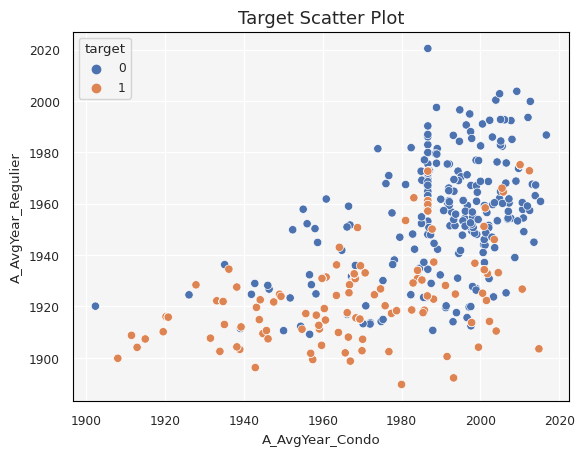

In [17]:
# Visualizing target variable scatter using two features

# Applying over/under sampling
df_x_explore, df_y_explore = sampling_func(X, Y, ovsamp_strat=0, unsamp_strat=1.0)

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.8,
)

sns.scatterplot(
    x=df_x_explore["A_AvgYear_Condo"],
    y=df_x_explore["A_AvgYear_Regulier"],
    hue=df_y_explore["target"],
)
plt.title("Target Scatter Plot", fontsize=13);

# Section 3 - Data Preprocessing

In [18]:
# Setting the over sampling and undersampling strategy (adjusted based on user needs)
OV_SAMP = 0
UN_SAMP = 0.25

In [19]:
# Splitting data into train (includes validation) and test sets
X_train, Y_train = X.loc[(X.index < "2021")].copy(), Y.loc[(Y.index < "2021")].copy()
X_test, Y_test = X.loc[(X.index >= "2021")].copy(), Y.loc[(X.index >= "2021")].copy()

print(
    f"""
Train set range:  {min(X_train.index).date().replace(day=1)} to {max(X_train.index).date()}
Test set range:  {min(X_test.index).date().replace(day=1)} to {max(X_test.index).date()}
"""
)


Train set range:  2015-12-01 to 2020-12-31
Test set range:  2021-01-01 to 2022-07-31



#### Random Forest

In [20]:
# Generating the k-fold training & validation sets with indeces for hyperparameter tuning
df_x_rf, df_y_rf, index_tuples_rf, _, _, _, _ = kfolds_func(
    X_train,
    Y_train,
    ovsamp_strat=OV_SAMP,
    unsamp_strat=UN_SAMP,
    n_splits=10,
)

In [21]:
# Finalizing the train and test data for the final model
X_train_rf, Y_train_rf = sampling_func(
    X_train, Y_train, ovsamp_strat=OV_SAMP, unsamp_strat=UN_SAMP
)
X_test_rf, Y_test_rf = X_test, Y_test

#### Logistic Regression

In [22]:
# Generating the k-fold training & validation sets with indeces for hyperparameter tuning
df_x_lr, df_y_lr, index_tuples_lr, _, _, _, _ = kfolds_func(
    X_train,
    Y_train,
    ovsamp_strat=OV_SAMP,
    unsamp_strat=UN_SAMP,
    n_splits=10,
    scale_values=True,
)

In [23]:
# Scaling data for logistic regression which uses gradient descent
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Finalizing the train and test data for the final model
X_train_lr, Y_train_lr = sampling_func(
    X_train_scaled, Y_train, ovsamp_strat=OV_SAMP, unsamp_strat=UN_SAMP
)
X_test_lr, Y_test_lr = X_test_scaled, Y_test

# Section 4 - Feature Selection
> Results of feature selection can be seen visually in Section 5 plots

#### Random Forest

In [24]:
# Initializing model to use for feature selection
RF_selector_model = RandomForestClassifier(random_state=1, class_weight="balanced")

# Recursively removing the lowest performing feature(s)
selector_rf = RFECV(
    RF_selector_model, step=1, cv=iter(index_tuples_rf), scoring="roc_auc"
)
selector_rf = selector_rf.fit(df_x_rf, df_y_rf["target"])

# Storing the cross-validation results
selectors_df_rf = pd.DataFrame(selector_rf.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# Storing the set of features resulting from the highest validation score
selected_features_rf = X.columns[selector_rf.support_]

display(selectors_df_rf[0:3])
print(
    f"\n{sum(selector_rf.support_)} out of {len(selector_rf.support_)} features selected\n"
)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
32,0.914468,0.016774,0.926938,0.898380,0.901230,0.927783,0.888271,0.920172,0.917975,0.893321,0.935217,0.935393
28,0.914305,0.016828,0.922426,0.904688,0.902820,0.926872,0.882482,0.924312,0.917951,0.892927,0.933275,0.935296
33,0.913966,0.016302,0.924624,0.899721,0.903065,0.928703,0.889493,0.914202,0.919355,0.891235,0.936402,0.932861



33 out of 35 features selected



#### Logistic Regression

In [25]:
# Initializing model to use for feature selection
LR_selector_model = LogisticRegression(
    penalty="none", solver="newton-cg", class_weight="balanced", random_state=1
)

# Recursively removing the lowest performing feature(s)
selector_lr = RFECV(
    LR_selector_model, step=1, cv=iter(index_tuples_lr), scoring="roc_auc"
)
selector_lr = selector_lr.fit(df_x_lr, df_y_lr["target"])

# Storing the cross-validation results
selectors_df_lr = pd.DataFrame(selector_lr.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# Storing the set of features resulting from the highest validation score
selected_features_lr = X.columns[selector_lr.support_]

display(selectors_df_lr[0:3])
print(
    f"\n{sum(selector_lr.support_)} out of {len(selector_lr.support_)} features selected\n"
)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
34,0.892163,0.015500,0.881275,0.878717,0.887215,0.914499,0.890794,0.874197,0.905355,0.870485,0.911386,0.907711
33,0.892156,0.015462,0.881275,0.878717,0.887215,0.914462,0.890794,0.874188,0.905355,0.870615,0.911377,0.907562
30,0.892135,0.015452,0.881227,0.878822,0.887377,0.914462,0.890887,0.874021,0.905132,0.870550,0.911312,0.907562



35 out of 35 features selected



# Section 5 - Hyperparamater Tuning

#### Random Forest

In [26]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_rf = pd.DataFrame()

search_space_rf = {
    "n_estimators": Integer(60, 250),
    "max_features": Integer(2, 20),
    "max_leaf_nodes": Integer(30, 160),
    # "max_depth": Integer(2, 20),
    # "min_samples_split": Integer(2, 120),
    # "min_impurity_decrease": Real(0, 0.25),
}

# Running scores twice to compare results using selected features vs. all features
for select_features in [X.columns, selected_features_rf]:
    RF_model = RandomForestClassifier(random_state=1, class_weight="balanced")

    BSCV_rf = BayesSearchCV(
        RF_model,
        search_space_rf,
        n_iter=35,
        cv=iter(index_tuples_rf),
        scoring="roc_auc",
        random_state=1,
    )
    BSCV_rf.fit(df_x_rf[select_features], df_y_rf["target"])

    # Combining the results tables using different sets of features
    results_df_rf = pd.concat(
        [
            results_df_rf,
            pd.DataFrame(BSCV_rf.cv_results_).assign(
                features_count=len(select_features)
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_rf = results_df_rf.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_rf = results_df_rf.iloc[0]["params"]

# Reverting to all features if performance is better
if results_df_rf.iloc[0]["features_count"] == len(X.columns):
    selected_features_rf = X.columns
    print(
        f"\nFeatures reverted back to all {len(selected_features_rf)} out of {len(X.columns)}\n"
    )

display(results_df_rf[0:3])

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,features_count
0,33,0.593252,0.008708,0.082691,0.002171,2,84,250,"{'max_features': 2, 'max_leaf_nodes': 84, 'n_e...",0.927824,0.913952,0.914565,0.938084,0.901750,0.925734,0.929479,0.903446,0.940221,0.941081,0.923614,0.013809,1,33
1,24,0.581949,0.009831,0.081639,0.002589,2,93,250,"{'max_features': 2, 'max_leaf_nodes': 93, 'n_e...",0.927882,0.912946,0.914029,0.937786,0.901378,0.926607,0.929302,0.903594,0.940788,0.941768,0.923608,0.014092,2,33
2,30,0.585290,0.010598,0.081109,0.001355,2,88,250,"{'max_features': 2, 'max_leaf_nodes': 88, 'n_e...",0.927671,0.914019,0.914173,0.937805,0.901713,0.926078,0.929358,0.903269,0.940890,0.940997,0.923597,0.013901,3,33


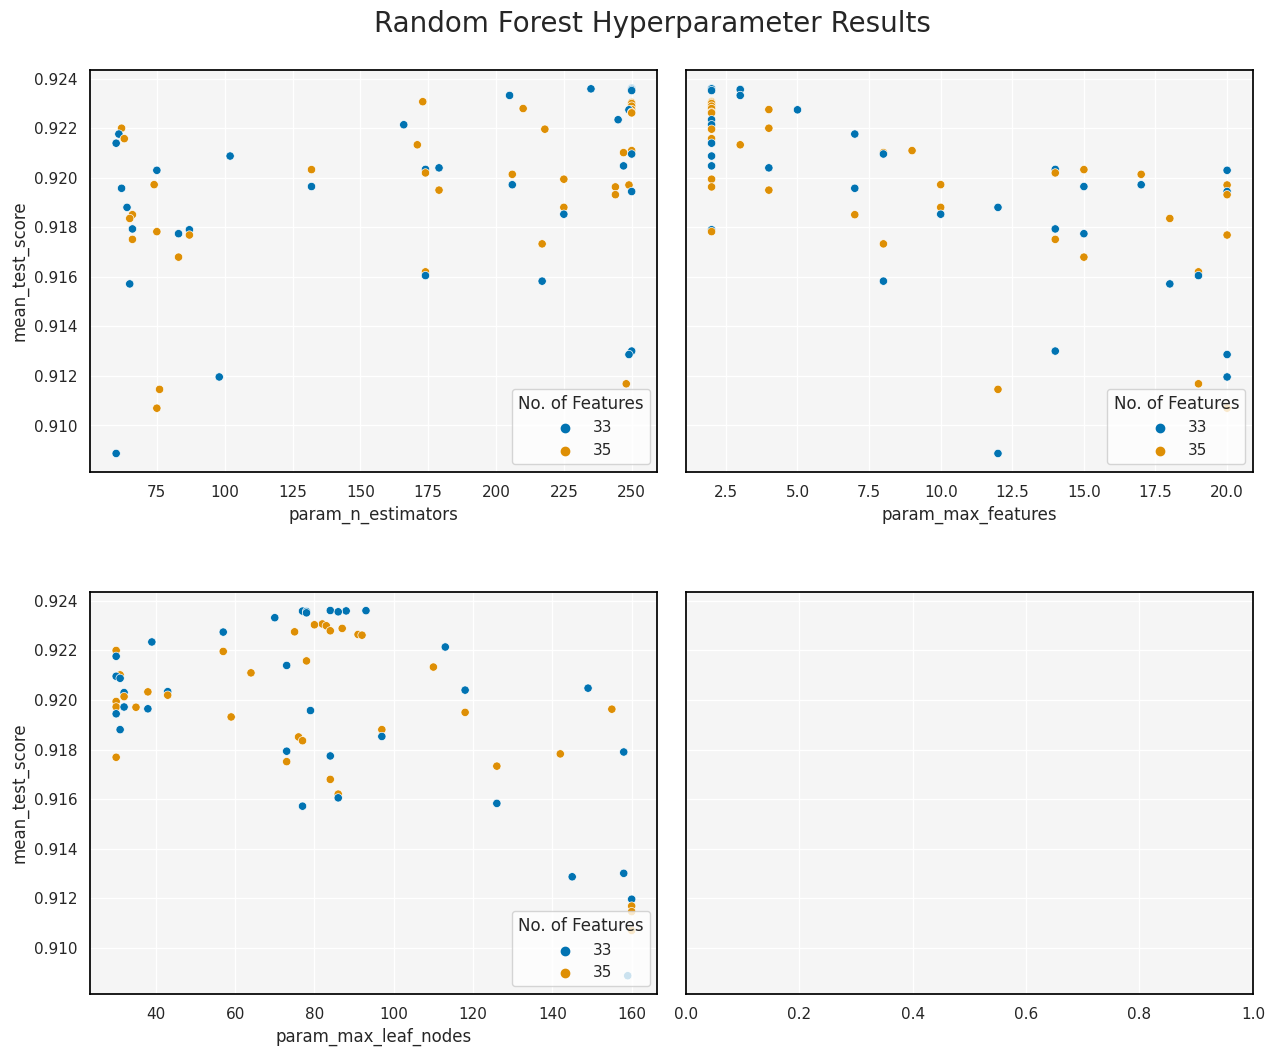

In [27]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space_rf, axs.ravel())):
    sns.scatterplot(
        data=results_df_rf,
        x="param_" + param_category,
        y="mean_test_score",
        hue="features_count",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white", loc="lower right").set_title("No. of Features")

plt.subplots_adjust(wspace=0.05, hspace=0.3)
fig.suptitle("Random Forest Hyperparameter Results", y=0.93, fontsize=20);

#### Logistic Regression

In [28]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_lr = pd.DataFrame()

search_space_lr = {"C": Real(0.05, 2)}

# Running scores twice to compare results using selected features vs. all features
for select_features in [X.columns, selected_features_lr]:
    LR_model = LogisticRegression(
        penalty="l1", solver="liblinear", class_weight="balanced", random_state=1
    )
    BSCV_lr = BayesSearchCV(
        LR_model,
        search_space_lr,
        n_iter=35,
        cv=iter(index_tuples_lr),
        scoring="roc_auc",
        random_state=1,
    )
    BSCV_lr.fit(df_x_lr[select_features], df_y_lr["target"])

    # Combining the results tables using different sets of features
    results_df_lr = pd.concat(
        [
            results_df_lr,
            pd.DataFrame(BSCV_lr.cv_results_).assign(
                features_count=len(select_features)
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_lr = results_df_lr.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_lr = results_df_lr.iloc[0]["params"]

# Reverting to all features if performance is better
if results_df_lr.iloc[0]["features_count"] == len(X.columns):
    selected_features_lr = X.columns
    print(
        f"\nFeatures reverted back to all {len(selected_features_lr)} out of {len(X.columns)}\n"
    )

display(results_df_lr[0:3])


Features reverted back to all 35 out of 35



,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,features_count
0,27,0.021951,0.001722,0.006106,0.000482,0.310451,{'C': 0.3104505892689136},0.869927,0.877366,0.890826,0.912701,0.885437,0.892634,0.894455,0.884851,0.912260,0.919313,0.893977,0.015327,1,35
1,27,0.022233,0.001710,0.006220,0.000435,0.310451,{'C': 0.3104505892689136},0.869927,0.877366,0.890826,0.912701,0.885437,0.892634,0.894455,0.884851,0.912260,0.919313,0.893977,0.015327,1,35
2,21,0.028103,0.013739,0.009972,0.005715,0.30854,{'C': 0.30854040691884677},0.869822,0.877299,0.890826,0.912710,0.885409,0.892620,0.894390,0.884861,0.912227,0.919331,0.893950,0.015352,2,35


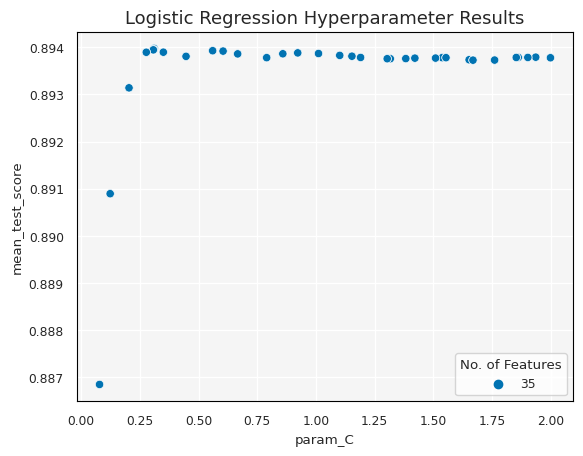

In [29]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.8,
)

sns.scatterplot(
    data=results_df_lr,
    x="param_C",
    y="mean_test_score",
    hue="features_count",
    palette="colorblind",
)
plt.title("Logistic Regression Hyperparameter Results", fontsize=13)
plt.legend(facecolor="white", loc="lower right").set_title("No. of Features");

# Section 6 - Baseline Predictions
> Baseline predictions reflects 5-year historical averages of the fire count densities (per month and per census tract area)

In [30]:
# Preparing the data for the baseline predictions
df_baseline = df.pipe(data_clean_func).pipe(fire_counts_func)
df_baseline["month"] = df_baseline.index.month
df_baseline["5_year_mean"] = 0
df_baseline = df_baseline[["count", "CT_DGUID", "month", "5_year_mean"]]

# Isolating a five year period [2016, 2020] for the averages
df_train_bl = df_baseline.loc[
    (df_baseline.index > "2015") & (df_baseline.index < "2021")
].copy()
df_test_bl = df_baseline.loc[(df_baseline.index >= "2021")].copy()

# Filtering through each census tract area and month combination
for dguid in CT_DGUID_UNIQUE:
    for month in range(1, 13):
        # Averaging the fire count density
        df_test_bl.loc[
            (df_test_bl["CT_DGUID"] == dguid) & (df_test_bl["month"] == month),
            ["5_year_mean"],
        ] = df_train_bl.loc[
            (df_train_bl["CT_DGUID"] == dguid) & (df_train_bl["month"] == month)
        ][
            "count"
        ].mean()

        # Setting the future date's value as the current date's target
        df_test_bl.loc[(df_test_bl["CT_DGUID"] == dguid), ["target"]] = df_test_bl.loc[
            (df_test_bl["CT_DGUID"] == dguid)
        ]["5_year_mean"].shift(-1)

# Dropping rows capturing dates at the limit of the sliding window
df_test_bl = df_test_bl.dropna()

# Section 7 - Final Model Results
> Models evaluated on test data spanning 2021-01-01 to 2022-07-31

#### Random Forest

In [31]:
# Fitting the final model using the best hyperparameters
RF_final_model = RandomForestClassifier(**BSCV_rf.best_params_, random_state=1)
RF_final_model.fit(X_train_rf[selected_features_rf], Y_train_rf["target"])

# Generating probability predictions
Y_proba_rf = RF_final_model.predict_proba(X_test_rf[selected_features_rf])

# Generating ROC AUC metrics
roc_auc_rf = roc_auc_score(Y_test, Y_proba_rf[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_proba_rf[:, 1], pos_label=1)

#### Logistic Regression

In [32]:
# Fitting the final model using the best hyperparameters
LR_final_model = LogisticRegression(**BSCV_lr.best_params_, random_state=1)
LR_final_model.fit(X_train_lr[selected_features_lr], Y_train_lr["target"])

# Generating probability predictions
Y_proba_lr = LR_final_model.predict_proba(X_test_lr[selected_features_lr])

# Generating ROC AUC metrics
roc_auc_lr = roc_auc_score(Y_test, Y_proba_lr[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(Y_test, Y_proba_lr[:, 1], pos_label=1)

#### Baseline Predictions

In [33]:
# Normalizing target average values for pseudo probability values
df_test_bl["proba"] = df_test_bl["target"] / df_test_bl["target"].max()

# Generating ROC AUC metrics
roc_auc_bl = roc_auc_score(Y_test, df_test_bl["proba"])
fpr_bl, tpr_bl, _ = roc_curve(Y_test, df_test_bl["proba"], pos_label=1)

#### All Models

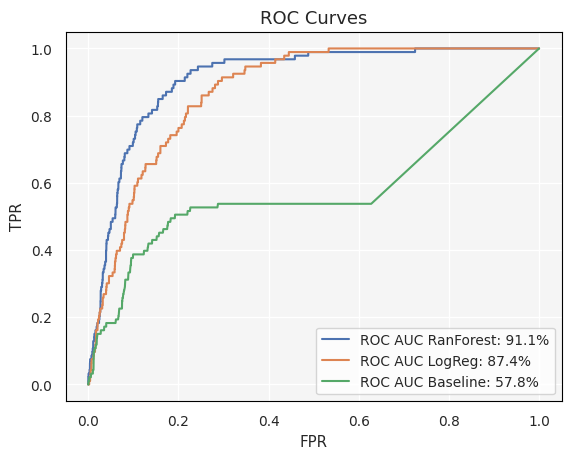

In [34]:
# Plotting the ROC curves for all models

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.9,
)

plt.plot(fpr_rf, tpr_rf, label=f"ROC AUC RanForest: {roc_auc_rf:.1%}")
plt.plot(fpr_lr, tpr_lr, label=f"ROC AUC LogReg: {roc_auc_lr:.1%}")
plt.plot(fpr_bl, tpr_bl, label=f"ROC AUC Baseline: {roc_auc_bl:.1%}")
plt.title("ROC Curves", fontsize=13)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(facecolor="white", loc="lower right");

#### Random Forest


Random Forest Model:
**Metrics for probability threshold value of 20.0%**
╒══════════════════════╤═══════════════════════╤═══════════╕
│ True Positive Rate   │ False Positive Rate   │ ROC AUC   │
╞══════════════════════╪═══════════════════════╪═══════════╡
│ 90.3%                │ 20.3%                 │ 91.1%     │
╘══════════════════════╧═══════════════════════╧═══════════╛



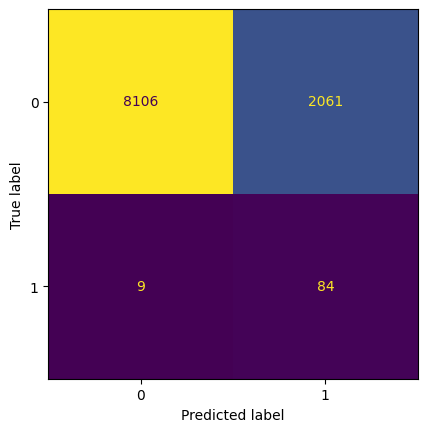

In [35]:
# Generating final Random Forest model metrics

# Selecting a probability threshold to evaluate model metrics at
PROBA_THRESHOLD = 0.20
Y_pred_rf = (Y_proba_rf[:, 1] >= PROBA_THRESHOLD).astype(int)

# Confusion matrix values and results metrics
conf_mat = confusion_matrix(Y_test, Y_pred_rf)

TPR = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
FPR = conf_mat[0, 1] / (conf_mat[0, 1] + conf_mat[0, 0])

# Displaying metrics using a table
metrics_table = [
    ["True Positive Rate", "False Positive Rate", "ROC AUC"],
    [f"{TPR:.1%}", f"{FPR:.1%}", f"{roc_auc_rf:.1%}"],
]

print(
    f"""
Random Forest Model:
**Metrics for probability threshold value of {PROBA_THRESHOLD:.1%}**
{tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid")}
"""
)

# Displaying confusion matrix
plt.rcdefaults()
conf_mat_display = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
conf_mat_display.plot(colorbar=False);

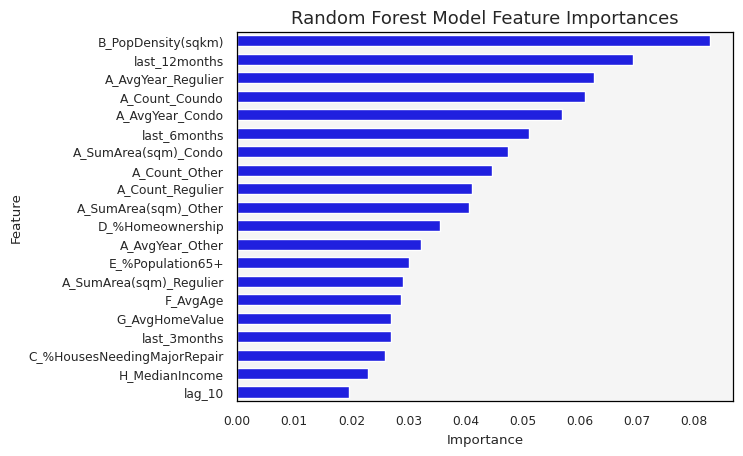

In [36]:
# Generating the final Random Forest model feature importances

# Creating dataframe with features ranked by importance
feature_importance_df = (
    pd.DataFrame(
        {
            "Feature": X_train_rf[selected_features_rf].columns,
            "Importance": RF_final_model.feature_importances_,
        }
    )
    .sort_values("Importance", ascending=False)
    .reset_index()
)

# Plotting the top 10 features with their importance %
sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df[0:20],
    color="blue",
    width=0.6,
)
plt.title("Random Forest Model Feature Importances", fontsize=13);

# Appendix - XGBoost

#### Data Preprocessing

In [37]:
# Generating the k-fold training & validation sets with indeces for hyperparameter tuning
df_x_xg, df_y_xg, index_tuples_xg = df_x_rf, df_y_rf, index_tuples_rf

In [38]:
# Finalizing the train and test data for the final model
X_train_xg, Y_train_xg = X_train_rf, Y_train_rf
X_test_xg, Y_test_xg = X_test, Y_test

#### Feature Selection

In [39]:
# Initializing model to use for feature selection
XG_selector_model = XGBClassifier(learning_rate=0.1, random_state=1)

# Recursively removing the lowest performing feature(s)
selector_xg = RFECV(
    XG_selector_model, step=1, cv=iter(index_tuples_xg), scoring="roc_auc"
)
selector_xg = selector_xg.fit(df_x_xg, df_y_xg["target"])

# Storing the cross-validation results
selectors_df_xg = pd.DataFrame(selector_xg.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

# Storing the set of features resulting from the highest validation score
selected_features_xg = X.columns[selector_xg.support_]

display(selectors_df_xg[0:3])
print(
    f"\n{sum(selector_xg.support_)} out of {len(selector_xg.support_)} features selected\n"
)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score
3,0.917632,0.020746,0.900301,0.915523,0.916395,0.945141,0.875382,0.917505,0.919861,0.901908,0.942874,0.941434
2,0.916781,0.020915,0.911888,0.914072,0.913943,0.944542,0.870406,0.907836,0.918086,0.904751,0.940625,0.941657
4,0.913993,0.022860,0.903754,0.911471,0.919796,0.942428,0.864459,0.914894,0.916878,0.889358,0.936541,0.940346



4 out of 35 features selected



#### Hyperparameter Tuning

In [40]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

results_df_xg = pd.DataFrame()

search_space_xg = {
    "n_estimators": Integer(80, 1000),
    "learning_rate": Real(0.005, 1.0, prior="log-uniform"),
    "subsample": Real(0.75, 1.0),
    "reg_lambda": Real(0.0, 50.0),
    "gamma": Real(0.0, 15.0),
    # "max_depth": Integer(2, 30),
    "colsample_bytree": Real(0.75, 1.0),
    "colsample_bylevel": Real(0.75, 1.0),
}

for select_features in [X.columns, selected_features_xg]:
    XGB_model = XGBClassifier(random_state=1)

    BSCV_xg = BayesSearchCV(
        XGB_model,
        search_space_xg,
        n_iter=100,
        cv=iter(index_tuples_xg),
        scoring="roc_auc",
        random_state=1,
    )
    BSCV_xg.fit(df_x_xg[select_features], df_y_xg["target"])

    # Combining the results tables using different sets of features
    results_df_xg = pd.concat(
        [
            results_df_xg,
            pd.DataFrame(BSCV_xg.cv_results_).assign(
                features_count=len(select_features)
            ),
        ],
        axis=0,
    )

# Sorting results table by score
results_df_xg = results_df_xg.sort_values(
    "mean_test_score", ascending=False
).reset_index()

# Storing the best hyperparameter values
best_params_xg = results_df_xg.iloc[0]["params"]

# Reverting to all features if performance is better
if results_df_xg.iloc[0]["features_count"] == len(X.columns):
    selected_features_xg = X.columns
    print(
        f"\nFeatures reverted back to all {len(selected_features_xg)} out of {len(X.columns)}\n"
    )

display(results_df_xg[0:3])

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_learning_rate,param_n_estimators,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,features_count
0,74,2.392026,0.950379,0.015897,0.000173,0.859632,0.75,0.0,0.005,539,0.0,0.75,"{'colsample_bylevel': 0.8596315631775688, 'col...",0.920831,0.912534,0.916405,0.944519,0.884647,0.930993,0.928076,0.910485,0.944965,0.952538,0.924599,0.019151,1,4
1,56,2.248031,0.302688,0.017044,0.000202,0.75,0.993791,0.0,0.005,623,0.0,0.75,"{'colsample_bylevel': 0.75, 'colsample_bytree'...",0.921051,0.912381,0.917008,0.944695,0.883987,0.929832,0.928243,0.910336,0.945021,0.952585,0.924514,0.019279,2,4
2,63,2.401636,0.579177,0.017390,0.000260,0.75,0.75,0.0,0.005,638,0.0,0.75,"{'colsample_bylevel': 0.75, 'colsample_bytree'...",0.920563,0.912659,0.916865,0.944760,0.884024,0.929256,0.928234,0.910243,0.945002,0.952297,0.924390,0.019224,3,4


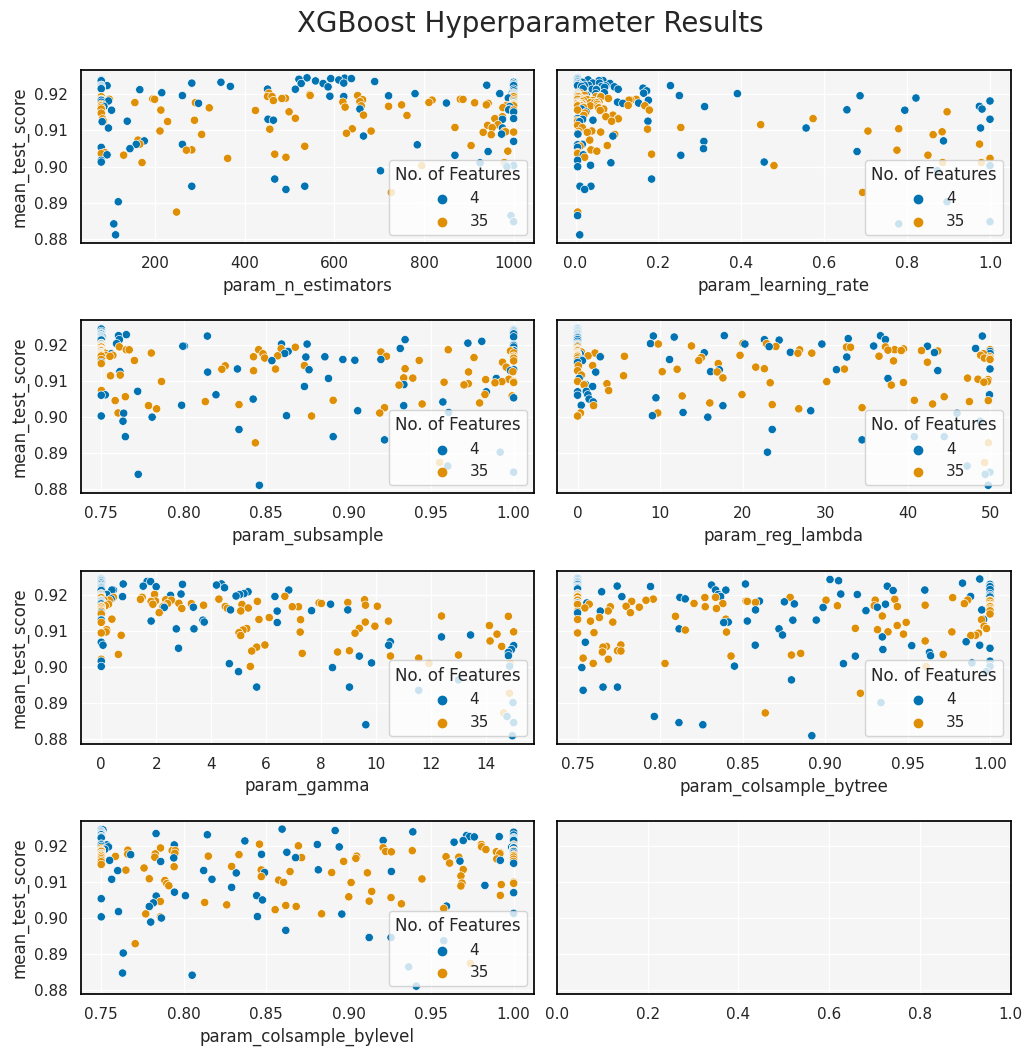

In [41]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=1
)

fig, axs = plt.subplots(4, 2, figsize=(12, 12), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space_xg, axs.ravel())):
    sns.scatterplot(
        data=results_df_xg,
        x="param_" + param_category,
        y="mean_test_score",
        hue="features_count",
        palette="colorblind",
        ax=ax,
    )
    ax.legend(facecolor="white", loc="lower right").set_title("No. of Features")

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("XGBoost Hyperparameter Results", y=0.93, fontsize=20);

#### Results

In [42]:
# Fitting the final model using the best hyperparameters
XG_final_model = XGBClassifier(**BSCV_xg.best_params_, random_state=1)
XG_final_model.fit(X_train_xg[selected_features_xg], Y_train_xg["target"])

# Generating probability predictions
Y_proba_xg = XG_final_model.predict_proba(X_test_xg[selected_features_xg])

# Generating ROC AUC metrics
roc_auc_xg = roc_auc_score(Y_test, Y_proba_xg[:, 1])
fpr_xg, tpr_xg, _ = roc_curve(Y_test, Y_proba_xg[:, 1], pos_label=1)

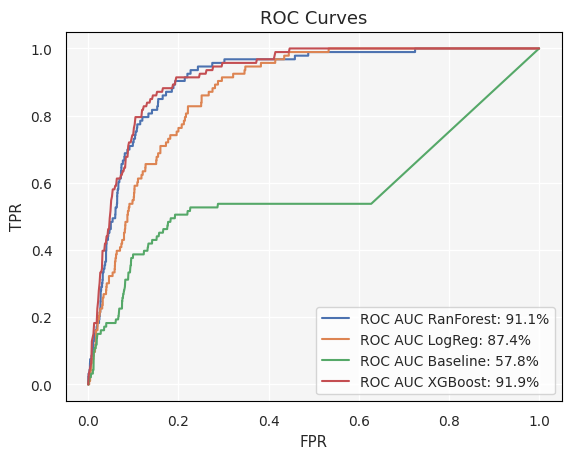

In [43]:
# Plotting the ROC curves for all models

sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.9,
)

plt.plot(fpr_rf, tpr_rf, label=f"ROC AUC RanForest: {roc_auc_rf:.1%}")
plt.plot(fpr_lr, tpr_lr, label=f"ROC AUC LogReg: {roc_auc_lr:.1%}")
plt.plot(fpr_bl, tpr_bl, label=f"ROC AUC Baseline: {roc_auc_bl:.1%}")
plt.plot(fpr_xg, tpr_xg, label=f"ROC AUC XGBoost: {roc_auc_xg:.1%}")
plt.title("ROC Curves", fontsize=13)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(facecolor="white", loc="lower right");

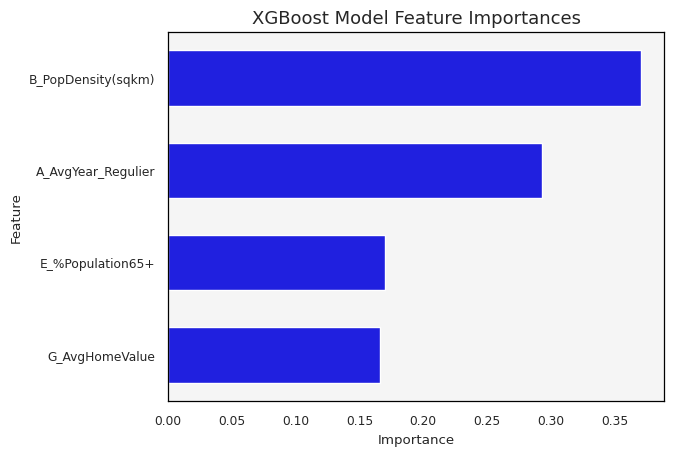

In [44]:
# Generating the final XGBoost model feature importances

# Creating dataframe with features ranked by importance
feature_importance_df = (
    pd.DataFrame(
        {
            "Feature": X_train_xg[selected_features_xg].columns,
            "Importance": XG_final_model.feature_importances_,
        }
    )
    .sort_values("Importance", ascending=False)
    .reset_index()
)

# Plotting the top 10 features with their importance %
sns.set_theme(
    rc={
        "axes.facecolor": "whitesmoke",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.9,
        "axes.grid": False,
    },
    font_scale=0.8,
)

sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df[0:20],
    color="blue",
    width=0.6,
)
plt.title("XGBoost Model Feature Importances", fontsize=13);